# Analysis of mondal2023cell2doc

In this notebook we analyse the outputs of the cells from the Cell2Doc dataset. Outputs can have 3 `output_type`:

1. `"stream"`: this indicates that the output was printed to stdout (since we did not collect outputs printed to stderr), the output will always be plain text.
2. `"display_data"` or `"execute_result"` these can have plain text and png outputs.

We are interested in finding missed opportunies in outputs that may have been analysed manually. For `display_data` and `execute_result` the output may simply be from the last statement in the cell. Thus we cannot be certain if the output was used for testing something manually.

Print statements on the other hand are very intentional, here we can be sure that the developer wanted to see the output (possibly to test/monitor/debug something).

In [4]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

sns.set_theme(context="talk", style="whitegrid", palette="colorblind")

In [7]:
# NOTE: takes 23s to execute
outputs = pd.read_csv(
    "data/shome2023notebook/mondal2023cell2doc-outputs.csv",
    header=None,
    names=["notebook", "source", "output_type", "text", "image", "has_html"],
    usecols=lambda x: x in ["notebook", "source", "output_type", "text"],
    # engine="pyarrow",
)
# outputs = outputs.loc[outputs["text/plain"].notna()]
outputs.head()

,notebook,source,output_type,text
1.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,import numpy as np \nimport pandas as pd \n\...,stream,Train with outlier:\nr2: 0.574804890299\nrmse:...
2.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,import matplotlib.pyplot as plt\n\n%matplotlib...,display_data,<matplotlib.figure.Figure at 0x7fc474ebb7b8>
4.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,train_labels = pd.read_csv('../input/prostate-...,execute_result,image_id data_provi...
8.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,%time biopsy = openslide.OpenSlide(path)\n%tim...,stream,"CPU times: user 482 µs, sys: 9.86 ms, total: 1..."
9.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,"%timeit img = biopsy.get_thumbnail(size=(331, ...",stream,190 ms ± 3.56 ms per loop (mean ± std. dev. of...


In [166]:
outputs.loc[outputs["output_type"] == "execution_result"]

,notebook,source,output_type,text,ast,print_nodes


In [ ]:
# CASE 1: work being done in cell? or assert over multiple elements
for test in tests:
    print(test)


# CASE 2: 
print(len(outputs)) -> less experienced dev; but still valid
len(outputs)

In [157]:
outputs = outputs.loc[outputs["output_type"] == "stream"]
outputs = outputs.dropna()
outputs.shape

(33556, 6)

## Data Pre-processing

Lets remove cells that do not have a valid AST.

**NOTE** This will remove cells that contain (very)magic commands as well.

In [9]:
def get_ast(source: str) -> ast.Module:
    try:
        tree = ast.parse(source)
    except SyntaxError:
        tree = None
    finally:
        return tree

outputs.loc[:, "ast"] = outputs["source"].apply(get_ast)
outputs = outputs.loc[outputs["ast"].notna()]
outputs.shape

<unknown>:6: SyntaxWarning: invalid escape sequence '\D'
<unknown>:3: SyntaxWarning: invalid escape sequence '\D'
<unknown>:96: SyntaxWarning: invalid escape sequence '\D'
<unknown>:96: SyntaxWarning: invalid escape sequence '\D'
<unknown>:4: SyntaxWarning: invalid escape sequence '\('
<unknown>:10: SyntaxWarning: invalid escape sequence '\.'
<unknown>:12: SyntaxWarning: invalid escape sequence '\!'
<unknown>:14: SyntaxWarning: invalid escape sequence '\?'
<unknown>:16: SyntaxWarning: invalid escape sequence '\,'
<unknown>:7: SyntaxWarning: invalid escape sequence '\-'
<unknown>:7: SyntaxWarning: invalid escape sequence '\-'
<unknown>:11: SyntaxWarning: invalid escape sequence '\.'
<unknown>:11: SyntaxWarning: invalid escape sequence '\.'
<unknown>:12: SyntaxWarning: invalid escape sequence '\.'
<unknown>:7: SyntaxWarning: invalid escape sequence '\-'
<unknown>:8: SyntaxWarning: invalid escape sequence '\-'
<unknown>:8: SyntaxWarning: invalid escape sequence '\*'
<unknown>:9: SyntaxWar

(33556, 5)

# Analysis of `print` statements

+ How many cells with print statements vs. without?
+ avg. number of print statements in a cell?
+ top nodes in the arguments of the print statement?
+ top functions used inside print statements?
+ analysis of the strings used inside print statement?
+ TODO: now many cells have implicit vs. explicit `print` statements?

In [20]:
class PrintCollector(ast.NodeVisitor):
    def __init__(self):
        self.nodes = []

    def visit_Call(self, node):
        if (isinstance(node.func, ast.Name) and node.func.id == "print"):
            self.nodes.append(node)

nodes = []

for _, tree in outputs["ast"].items():
    collector = PrintCollector()
    collector.generic_visit(tree)
    nodes.append(collector.nodes)
outputs.loc[:, "print_nodes"] = pd.Series(data=nodes)

In [43]:
print(f"cells w/o print statements: {len(outputs.loc[outputs["print_nodes"].apply(lambda x: len(x) == 0)])}")
print(f"cells w/ print statements: {len(outputs.loc[outputs["print_nodes"].apply(lambda x: len(x) > 0)])}")

cells w/o print statements: 11583
cells w/ print statements: 21973


We hae 11K cells which produced an output in stdout but did not contain a print statement. This means that they likely called a function which internally produces an output to stdout (probably also through a print statement, but we don't have access to the source code in the cell itself).

Majority of the cells do contain a print statement.

<Axes: ylabel='print_nodes'>

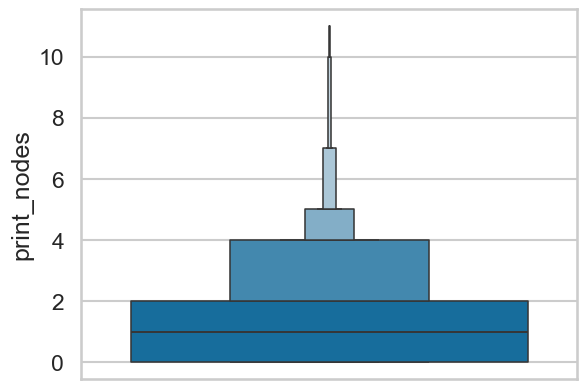

In [50]:
# NOTE: distribution of number of print statements in our data
sns.boxenplot(data=outputs["print_nodes"].apply(lambda x: len(x)))

In [40]:
# NOTE: print random sample of print statements
prints = outputs["print_nodes"].explode().dropna()
for id, node in prints.sample(10).items():
    print(ast.unparse(node))

print('Done: %.1fs' % (time.time() - t0))
print('Training')
print('Done: %.1fs' % (time.time() - t0))
print(os.listdir('../input'))
print('Train data: ', len(train_index))
print('Train without outlier:')
print('train_dataset', len(trainDataset), 'valid_dataset', len(validDataset))
print(df_trn['IsTemp'].value_counts())
print('Done: %.1fs' % (time.time() - t0))
print(df_trn['IsTemp'].value_counts())


In [71]:
prints.shape

(45792,)

## Anatomy of `print` statements

Similar to Assertions, we need to understand the anatomy of print statements to identify if and how they are being used for testing in ML notebooks.

The analysis can be broken down into two segments:

1. Analysis of the natural text written inside print statements (using NLP techniques)
2. And analysis of the source code inside print statements.

Print statements appear as a `ast.Call` node where `Call.func` is a `Name` node and `Name.id == 'print'`. The arguments of the print statement are inside `Call.args`.

The natural language text appear as `ast.Constant` nodes.

### Analysis of natural language text in print statements

In [64]:
tests = [
    "print('a constant only', 'and another')",
    "print(f'a constant in f string {foo}')",
    "print('a formatted string with {} and {}'.format(foo, bar))"
]
for test in tests:
    print("==========")
    print("SOURCE:\n")
    print(test)
    print("AST:\n")
    print(ast.dump(ast.parse(test), indent=4))

SOURCE:

print('a constant only', 'and another')
AST:

Module(
    body=[
        Expr(
            value=Call(
                func=Name(id='print', ctx=Load()),
                args=[
                    Constant(value='a constant only'),
                    Constant(value='and another')],
                keywords=[]))],
    type_ignores=[])
SOURCE:

print(f'a constant in f string {foo}')
AST:

Module(
    body=[
        Expr(
            value=Call(
                func=Name(id='print', ctx=Load()),
                args=[
                    JoinedStr(
                        values=[
                            Constant(value='a constant in f string '),
                            FormattedValue(
                                value=Name(id='foo', ctx=Load()),
                                conversion=-1)])],
                keywords=[]))],
    type_ignores=[])
SOURCE:

print('a formatted string with {} and {}'.format(foo, bar))
AST:

Module(
    body=[
        Expr(
            

In [70]:
class StringCollector(ast.NodeVisitor):
    def __init__(self):
        self.corpus = []

    def visit_Constant(self, node):
        if isinstance(node.value, str):
            self.corpus.append(node.value)

collector = StringCollector()
for _, node in prints.items():
    collector.visit(node)

len(collector.corpus)

# NOTE: pre-process the corpus
# + remove special characters, punctuations
# + lower case?
# + lammatise words

43580

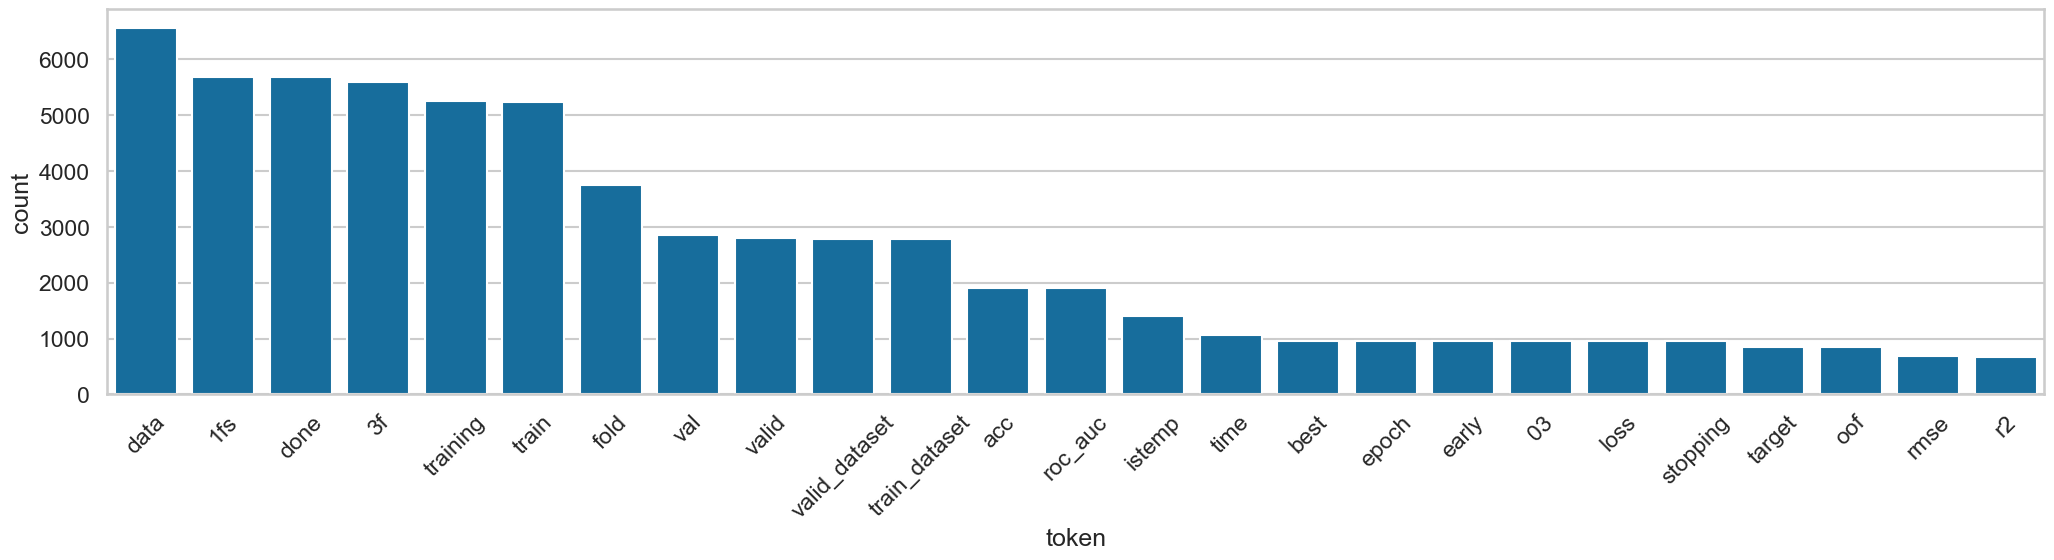

In [113]:
vectorizer = CountVectorizer(
    preprocessor=None,  # default, lowercase and ignore punctuations
    stop_words=None,  # default, experiment with 'english'
    analyzer="word",  # default
    ngram_range=(1, 1),  # default, experiment with bigrams (2,2)
)
X = vectorizer.fit_transform(collector.corpus)
occurances = pd.DataFrame(
    data={"token": vectorizer.get_feature_names_out(), "count": X.toarray().sum(axis=0)}
)

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(
    data=occurances.sort_values(by=["count"], ascending=False).head(25),
    x="token",
    y="count",
    ax=ax,
)
ax.tick_params(axis='x', rotation=45)

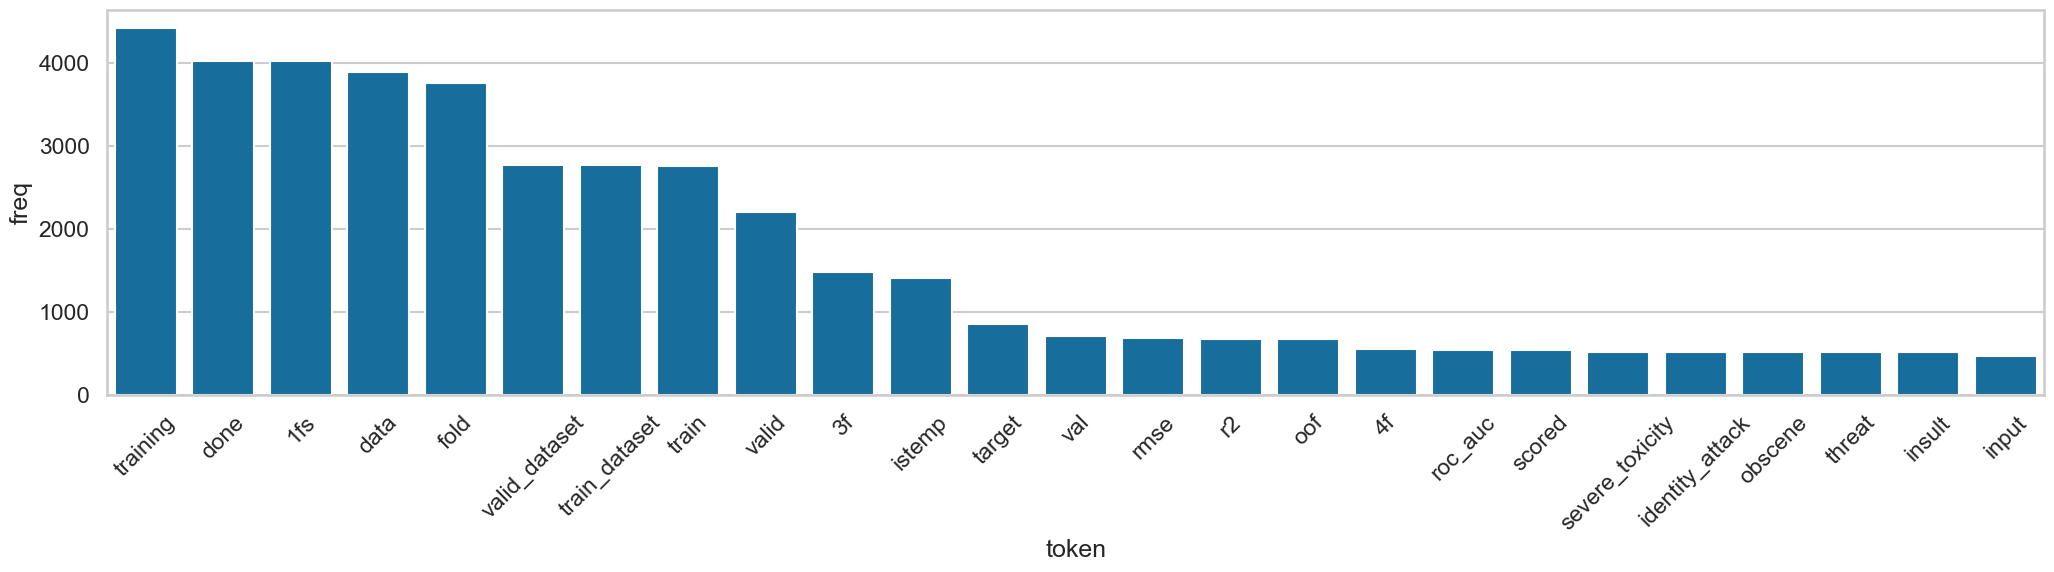

In [112]:
vectorizer = TfidfVectorizer(
    preprocessor=None,  # default
    stop_words=None,  # default
    analyzer='word',  # default
    ngram_range=(1,1),  # default
)
X = vectorizer.fit_transform(collector.corpus)
frequences = pd.DataFrame(
    data = {"token": vectorizer.get_feature_names_out(), "freq": X.toarray().sum(axis=0)}
)

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(
    data=frequences.sort_values(by=["freq"], ascending=False).head(25),
    x="token",
    y="freq",
    ax=ax,
)
ax.tick_params(axis='x', rotation=45)

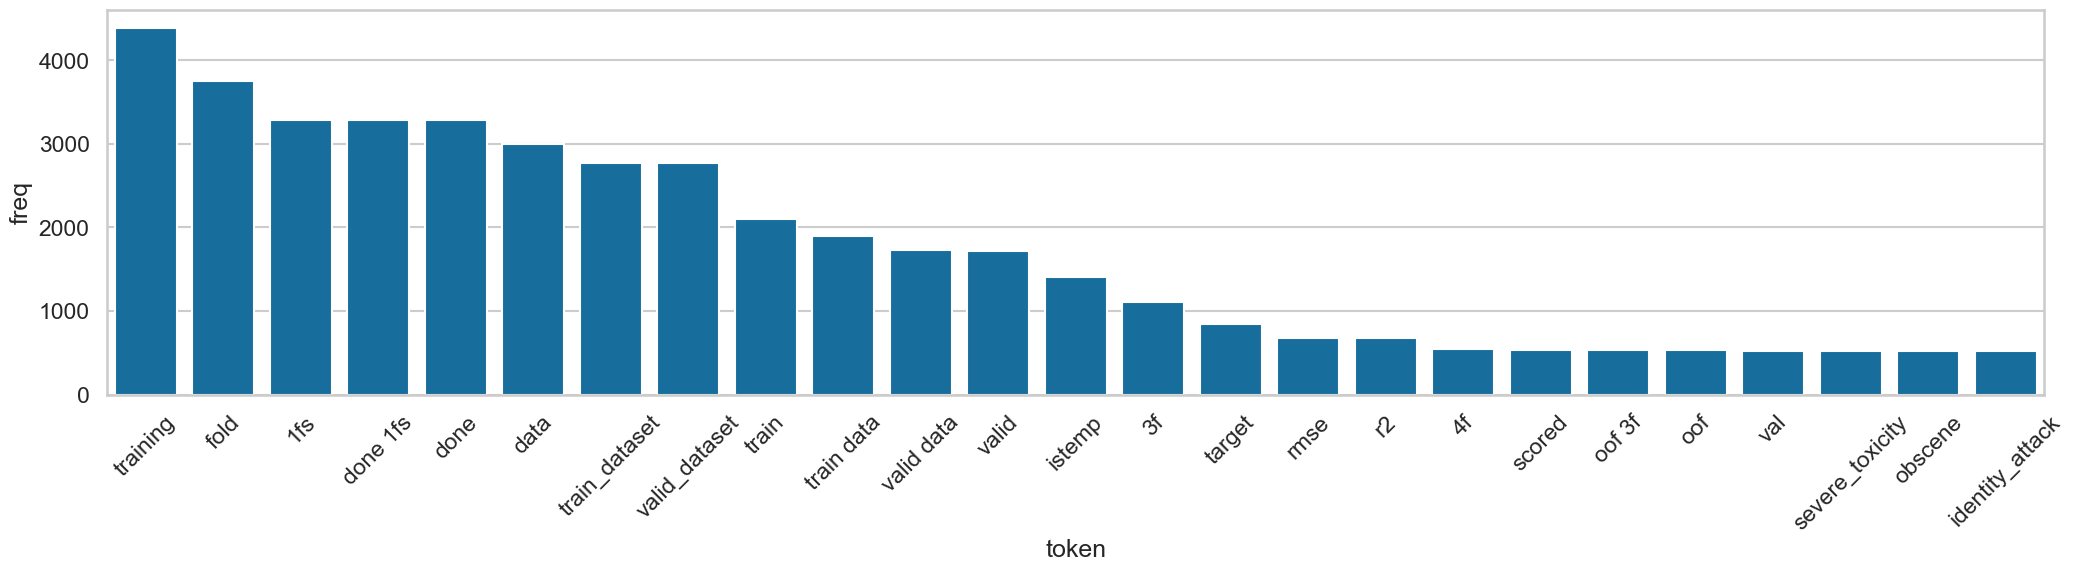

In [115]:
vectorizer = TfidfVectorizer(
    preprocessor=None,  # default
    stop_words=None,  # default
    analyzer='word',  # default
    ngram_range=(1,2),  # mono and bi-grams
)
X = vectorizer.fit_transform(collector.corpus)
frequences = pd.DataFrame(
    data = {"token": vectorizer.get_feature_names_out(), "freq": X.toarray().sum(axis=0)}
)

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(
    data=frequences.sort_values(by=["freq"], ascending=False).head(25),
    x="token",
    y="freq",
    ax=ax,
)
ax.tick_params(axis='x', rotation=45)

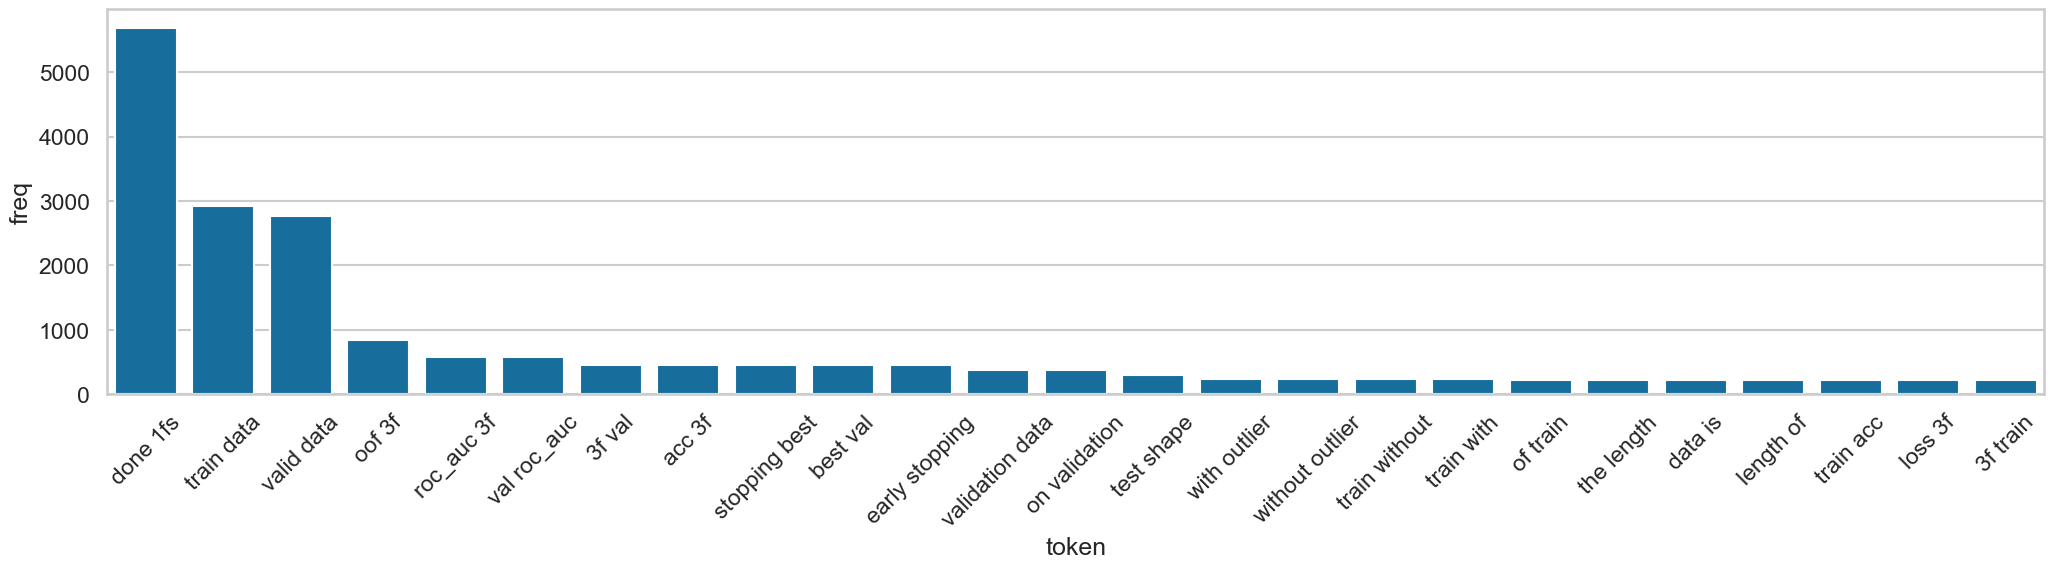

In [114]:
vectorizer = TfidfVectorizer(
    preprocessor=None,  # default
    stop_words=None,  # default
    analyzer='word',  # default
    ngram_range=(2,2),  # bi-grams
)
X = vectorizer.fit_transform(collector.corpus)
frequences = pd.DataFrame(
    data = {"token": vectorizer.get_feature_names_out(), "freq": X.toarray().sum(axis=0)}
)

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(
    data=frequences.sort_values(by=["freq"], ascending=False).head(25),
    x="token",
    y="freq",
    ax=ax,
)
ax.tick_params(axis='x', rotation=45)

### Analysis of function calls inside print statements

Here, we want to analyse the function calls which were passed as argument to the print statements.

In [125]:
tests = [
    "print(foo(x,y))",
    "print(baz.foo(x,y))",
    "print(bar.baz.foo(x,y))",
    "print('something to print{}'.format(foo))",
    "print('something to print{}'.format(foo(x, y)))"
]

for test in tests:
    print("==========")
    print("SOURCE:\n")
    print(test)
    print("AST:\n")
    print(ast.dump(ast.parse(test), indent=4))

SOURCE:

print(foo(x,y))
AST:

Module(
    body=[
        Expr(
            value=Call(
                func=Name(id='print', ctx=Load()),
                args=[
                    Call(
                        func=Name(id='foo', ctx=Load()),
                        args=[
                            Name(id='x', ctx=Load()),
                            Name(id='y', ctx=Load())],
                        keywords=[])],
                keywords=[]))],
    type_ignores=[])
SOURCE:

print(baz.foo(x,y))
AST:

Module(
    body=[
        Expr(
            value=Call(
                func=Name(id='print', ctx=Load()),
                args=[
                    Call(
                        func=Attribute(
                            value=Name(id='baz', ctx=Load()),
                            attr='foo',
                            ctx=Load()),
                        args=[
                            Name(id='x', ctx=Load()),
                            Name(id='y', ctx=Load())],
        

<Axes: xlabel='count', ylabel='print_nodes'>

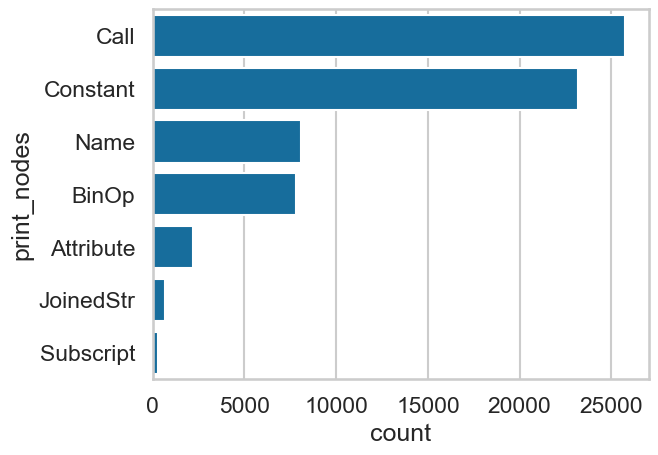

In [132]:
args = prints.apply(lambda x: x.args)
args = args.explode().dropna()

sns.barplot(
    data=args.apply(lambda x: x.__class__.__name__)
    .value_counts()
    .sort_values(ascending=False),
    orient="h",
)

In [133]:
indices = args.apply(lambda x: x.__class__.__name__ == 'Call')
calls = args.loc[indices]
calls.shape

(25758,)

In [151]:
# NOTE: NameCollector will ignore format function calls (since it never hits a Name node), analyse them separately.
class NameCollector(ast.NodeVisitor):
    def __init__(self):
        self.name = None
        self.stack = []

    def visit_Name(self, node: ast.Name) -> None:
        if self.stack:
            self.name = (node.id, self.stack[0].attr)
        else:
            self.name = (None, node.id)

    def visit_Attribute(self, node: ast.Attribute) -> None:
        self.stack.append(node)
        self.visit(node.value)

names = []
for _, node in calls.items():
    collector = NameCollector()
    collector.visit(node.func)
    names.append(collector.name)

names = pd.DataFrame(data=names, columns=["module", "function"])
names.shape

(25758, 2)

<Axes: xlabel='count', ylabel='function'>

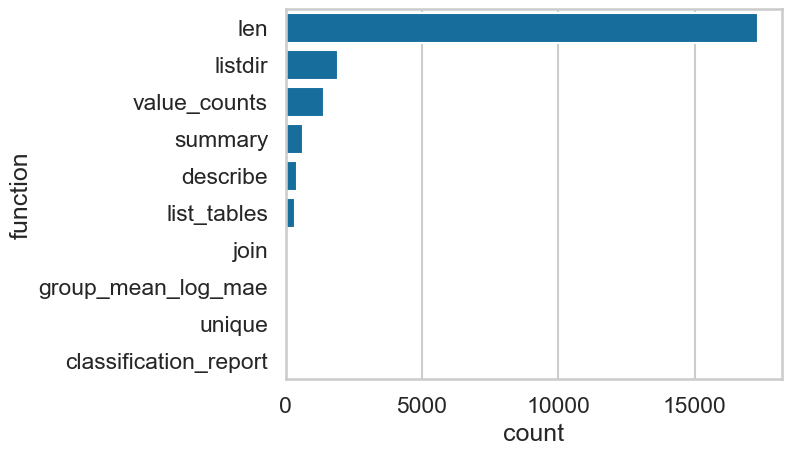

In [155]:
sns.barplot(
    data=names["function"].dropna().value_counts().sort_values(ascending=False).head(10),
    orient='h'
)

# Analysis of visualisations

In this section we perform descriptive and lexical analysis of code cells that produce a visualisation output.

In this analysis we focus on visualisations created using matplotlib and seaborn since those libraries are the most popular for creating notebooks.

We focus our analysis only on the line in the source code that produces the visualisation. We collect the top level module (if available), the function used (which indicates the type of plot), and the arguments passed.

We make the following specifications:

1. We look for the module abbreviations as per the official tutorials (`sns` for seaborn and `plt` for matplotlib)
2. We only collect visualisations produced using the functional style of programming (rather than object oriented); I vaguely remember there was a paper/blogpost that analysed this aspect

Seaborn is fairly straightforward to parse:

+ It has figure level functions: `relplot`, `displot` & `catplot` where we need to look at the `type` argument to know the exact figure type.
+ otherwise its a direct function call: `sns.histplot`

For matplotlib, we assume that the figure is created using the recommended way in the tutorial: `fig, ax = plt.subplots()`. Then we only look for the `ax.plot` type statements.

In [6]:
tests = [
    "sns.histplot(data=df, x='x', y='y')",
    "sns.distplot(data=df, x='x', y='y', type='hist')",
    "ax.plot(x, y)",
]

for test in tests:
    print("==========")
    print("SOURCE:\n")
    print(test)
    print("AST:\n")
    print(ast.dump(ast.parse(test), indent=4))

SOURCE:

sns.histplot(data=df, x='x', y='y')
AST:

Module(
    body=[
        Expr(
            value=Call(
                func=Attribute(
                    value=Name(id='sns', ctx=Load()),
                    attr='histplot',
                    ctx=Load()),
                args=[],
                keywords=[
                    keyword(
                        arg='data',
                        value=Name(id='df', ctx=Load())),
                    keyword(
                        arg='x',
                        value=Constant(value='x')),
                    keyword(
                        arg='y',
                        value=Constant(value='y'))]))],
    type_ignores=[])
SOURCE:

sns.distplot(data=df, x='x', y='y', type='hist')
AST:

Module(
    body=[
        Expr(
            value=Call(
                func=Attribute(
                    value=Name(id='sns', ctx=Load()),
                    attr='distplot',
                    ctx=Load()),
                args=[],
      

In [5]:
# NOTE: takes 23s to execute
visualisations = pd.read_csv(
    "data/shome2023notebook/mondal2023cell2doc-outputs.csv",
    header=None,
    names=["notebook", "source", "output_type", "text", "image", "has_html"],
    usecols=lambda x: x in ["notebook", "source", "output_type", "image"],
    engine="c",
)
visualisations.shape

(107406, 4)